# Qualitative Experiments on Hessian Approximations
This notebook demonstrates the qualitative experiments on comparing the performance of different Hessian Approximations in Laplace Approximation Bayesian Neural Network. 

In [1]:
# Standard imports
import os
import copy
import collections
import numpy as np
from numpy.linalg import inv, cholesky
from typing import Union, List, Any, Dict
from tqdm import tqdm
import torch
from torch import Tensor
from torch.nn import Module, Sequential
from torch.autograd import Variable
import torchvision
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# From the repository
from plot import surface_plot, regression_uncertainty, toy_regression_plot
from curvatures import Diagonal, KFAC, EFB, INF,Curvature, BlockDiagonal
from utils import calibration_curve,get_eigenvectors, kron 
from datasets import toy_regression_gen

D:\Ana\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Change this to 'cuda' if you have a working GPU.
device = 'cuda'

def train(model, data, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        training_loss = 0
        for i in tqdm(range(data.shape[0])):
            prediction = model(data[i][:-1].reshape(1,-1).to(device)) 
            # print(data[i][:-1],prediction,data[i][1:])
            loss = criterion(prediction, data[i][1:].reshape(1,-1).to(device))
            training_loss = training_loss + loss.item()
            model.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1} \t\t Training Loss: {training_loss / data.shape[0]}')
            
def eval(model, data):
    model.eval()
    predictions = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)
    features = torch.Tensor().to(device)

    with torch.no_grad():
        for i in tqdm(range(data.shape[0])):
            predictions = torch.cat([predictions, model(data[i][:-1].to(device))])
            features = torch.cat([features, data[i][:-1].to(device)])
            targets = torch.cat([targets, data[i][1:].to(device)])
    return features, targets, predictions

In [3]:
model = torch.nn.Sequential(
    torch.nn.Linear(1,7),
    torch.nn.ReLU(),
    torch.nn.Linear(7,7),
    torch.nn.ReLU(),
    torch.nn.Linear(7,1),
    ).to(device)

In [4]:
train_set, test_set = toy_regression_gen(sorted=False).to(device), toy_regression_gen(sorted=True).to(device)

In [5]:
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00075, weight_decay = 0.0001)

In [6]:
train(model, train_set, criterion, optimizer, epochs=40)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.22it/s]


Epoch 1 		 Training Loss: 605.3156367432589


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 118.07it/s]


Epoch 2 		 Training Loss: 343.7196763157146


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 124.69it/s]


Epoch 3 		 Training Loss: 307.8718206070794


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.70it/s]


Epoch 4 		 Training Loss: 284.4320444981604


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.92it/s]


Epoch 5 		 Training Loss: 268.9362053517252


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 119.19it/s]


Epoch 6 		 Training Loss: 255.4416208423674


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 121.36it/s]


Epoch 7 		 Training Loss: 246.3308101170417


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 118.90it/s]


Epoch 8 		 Training Loss: 235.22561001123978


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.70it/s]


Epoch 9 		 Training Loss: 227.41910265445244


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.15it/s]


Epoch 10 		 Training Loss: 222.66423403315247


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 125.79it/s]


Epoch 11 		 Training Loss: 217.1080137153715


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 127.55it/s]


Epoch 12 		 Training Loss: 211.95220022657887


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.35it/s]


Epoch 13 		 Training Loss: 207.79426416689066


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 113.50it/s]


Epoch 14 		 Training Loss: 203.89062074005605


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.10it/s]


Epoch 15 		 Training Loss: 201.08000447258354


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 118.62it/s]


Epoch 16 		 Training Loss: 198.06139698252082


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 118.34it/s]


Epoch 17 		 Training Loss: 194.1509865412116


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.61it/s]


Epoch 18 		 Training Loss: 192.16003476276993


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.63it/s]


Epoch 19 		 Training Loss: 189.53742292283104


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.36it/s]


Epoch 20 		 Training Loss: 188.18011889502407


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 121.21it/s]


Epoch 21 		 Training Loss: 186.86181648522614


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.46it/s]


Epoch 22 		 Training Loss: 185.48761052399874


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 125.00it/s]


Epoch 23 		 Training Loss: 184.60431635424496


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.19it/s]


Epoch 24 		 Training Loss: 183.22108547225594


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 116.69it/s]


Epoch 25 		 Training Loss: 182.34494901377474


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 106.39it/s]


Epoch 26 		 Training Loss: 181.67523654178717


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 114.28it/s]


Epoch 27 		 Training Loss: 179.65217308117076


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 118.49it/s]


Epoch 28 		 Training Loss: 179.4777942381799


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 116.69it/s]


Epoch 29 		 Training Loss: 179.05786642938853


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 115.34it/s]


Epoch 30 		 Training Loss: 180.04683176144957


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 115.21it/s]


Epoch 31 		 Training Loss: 178.98955731630326


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.15it/s]


Epoch 32 		 Training Loss: 179.82444322824477


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 113.38it/s]


Epoch 33 		 Training Loss: 178.6631335966289


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 122.55it/s]


Epoch 34 		 Training Loss: 180.0680531346798


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 119.05it/s]


Epoch 35 		 Training Loss: 180.02801897227764


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 118.91it/s]


Epoch 36 		 Training Loss: 180.03894434973597


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 117.10it/s]


Epoch 37 		 Training Loss: 180.07227633565665


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 107.41it/s]


Epoch 38 		 Training Loss: 179.6738112142682


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.92it/s]


Epoch 39 		 Training Loss: 179.73602354243397


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 126.42it/s]

Epoch 40 		 Training Loss: 179.95825206428765


In [7]:
sgd_features, sgd_targets, sgd_predictions = eval(model, test_set)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 564.97it/s]


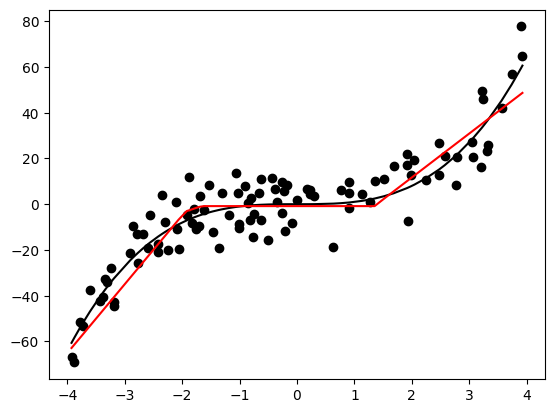

In [8]:
plt.plot(sgd_features.cpu().detach().numpy(), sgd_targets.cpu().detach().numpy(), marker="o", linestyle='None', color='black')
plt.plot(sgd_features.cpu().detach().numpy(), np.power(sgd_features.cpu().detach().numpy(), 3), color='black') 
plt.plot(sgd_features.cpu().detach().numpy(), sgd_predictions.cpu().detach().numpy(), color='red') 
plt.show()

In [47]:
# Constants
samples = 100  # 10 Monte Carlo samples from the weight posterior.
add = 15.0
multiply = 100.0

## Block Diagonal

In [48]:
blod_model = copy.deepcopy(model)
blod_model.train()
blod = BlockDiagonal(blod_model)

prediction = blod_model(train_set[:,:-1].to(device)) 
loss = criterion(prediction, train_set[:,1:].to(device))
blod_model.zero_grad()
loss.backward()
blod.update(batch_size=100)

In [49]:
blod.invert(add, multiply)

PyTorch Cholesky is singular. Using Numpy.


In [50]:
blod_predictions_list = torch.Tensor().to(device)

with torch.no_grad():
    for sample in range(samples):
        blod.sample_and_replace()
        blod_features, blod_targets, blod_predictions = eval(blod_model, test_set)
        blod_predictions_list = torch.cat([blod_predictions_list, blod_predictions.reshape(1,-1).to(device)], dim=0)
    blod_std_predictions, blod_mean_predictions = torch.std_mean(blod_predictions_list, dim=0)  

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 431.07it/s]


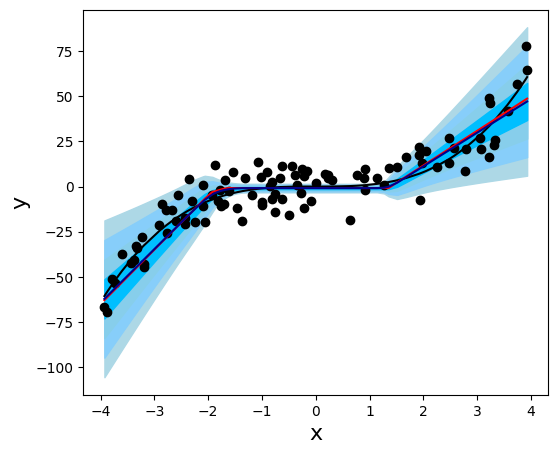

In [51]:
toy_regression_plot(blod_features, blod_targets, sgd_predictions, blod_mean_predictions, blod_std_predictions)

## The diagonal Fisher information matrix (FiM)

In [52]:
diag_model = copy.deepcopy(model)
diag_model.train()
diag = Diagonal(diag_model)

prediction = diag_model(train_set[:,:-1].to(device)) 
loss = criterion(prediction, train_set[:,1:].to(device))
diag_model.zero_grad()
loss.backward()
diag.update(batch_size=100)

In [53]:
diag.invert(add, multiply)

In [54]:
diag_predictions_list = torch.Tensor().to(device)

with torch.no_grad():
    for sample in range(samples):
        diag.sample_and_replace()
        diag_features, diag_targets, diag_predictions = eval(diag_model, test_set)
        diag_predictions_list = torch.cat([diag_predictions_list, diag_predictions.reshape(1,-1).to(device)], dim=0)
    diag_std_predictions, diag_mean_predictions = torch.std_mean(diag_predictions_list, dim=0) 

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 581.21it/s]


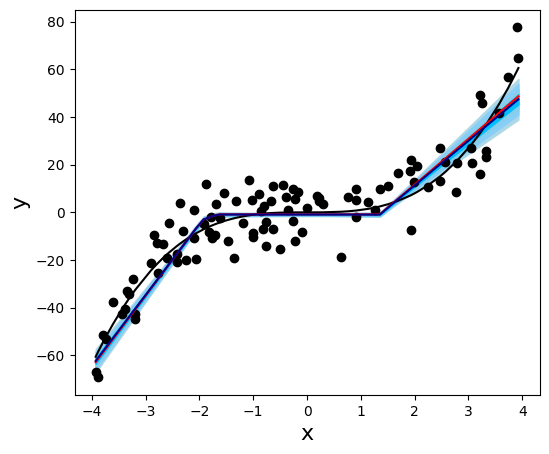

In [55]:
toy_regression_plot(diag_features, diag_targets, sgd_predictions, diag_mean_predictions, diag_std_predictions)

## Kronecker factorization

In [56]:
efb_model = copy.deepcopy(model)
efb_model.train()
efb_kfac = KFAC(efb_model)

prediction = efb_model(train_set[:,:-1].to(device)) 
loss = criterion(prediction, train_set[:,1:].to(device))
efb_model.zero_grad()
loss.backward()
efb_kfac.update(batch_size=100)

In [57]:
efb = EFB(efb_model, efb_kfac.state)

prediction = efb_model(train_set[:,:-1].to(device)) 
loss = criterion(prediction, train_set[:,1:].to(device))
efb_model.zero_grad()
loss.backward()
efb.update(batch_size=100)

In [58]:
efb.invert(add, multiply)

In [59]:
efb_predictions_list = torch.Tensor().to(device)

with torch.no_grad():
    for sample in range(samples):
        efb.sample_and_replace()
        efb_features, efb_targets, efb_predictions = eval(efb_model, test_set)
        efb_predictions_list = torch.cat([efb_predictions_list, efb_predictions.reshape(1,-1).to(device)], dim=0)
    efb_std_predictions, efb_mean_predictions = torch.std_mean(efb_predictions_list, dim=0)  

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 432.92it/s]


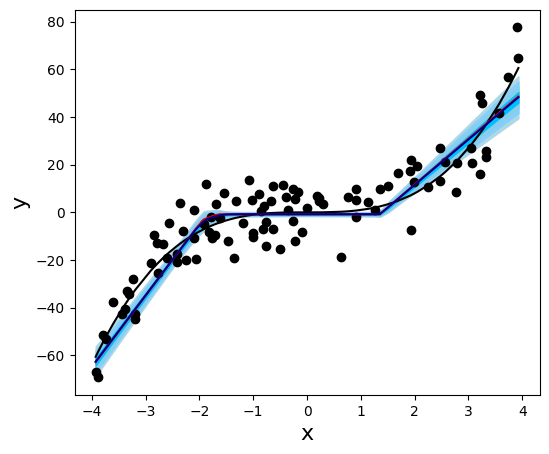

In [60]:
toy_regression_plot(efb_features, efb_targets, sgd_predictions, efb_mean_predictions, efb_std_predictions)